# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.


In [8]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'mark_twain.txt' # Other options are mark_twain.txt, charles_dickens.txt

download_file(f'https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/' + dataset, dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.1)

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [15]:
# Print the first 1000 characters of the dataset
print("First 1000 characters of the dataset:")
print(80 * '_')
print(text[:1000])
print(80 * '_')

# Report the size of the dataset
print(f"\nDataset length: {len(text)} characters")

# Calculate the number of unique characters in the dataset
unique_chars = set(text)
print(f"Number of unique characters: {len(unique_chars)}")

First 1000 characters of the dataset:
________________________________________________________________________________

The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [17]:
from keras.preprocessing.text import Tokenizer

# Number of unique words
unique_words = set(text.split())
print(f"Unique words: {len(unique_words)}")

# Define the size of the vocabulary. Here, we choose the top 10,000 most common words.
VOCAB_SIZE = 10000

# Define the Out-Of-Vocabulary (OOV) token to handle rare words
OOV_TOKEN = "<OOV>"

# Initialize the Tokenizer with the specified vocabulary size and OOV token
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Convert the text to lowercase as a standard preprocessing step
text_lower = text.lower()

# Fit the tokenizer on the text
tokenizer.fit_on_texts([text_lower])

# Convert the text to a sequence of integers
sequences = tokenizer.texts_to_sequences([text_lower])[0]

print("Tokenizer has been initialized and fitted on the text.")

Unique words: 25445
Tokenizer has been initialized and fitted on the text.


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [18]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('he', 9), ('it', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [23]:
SEQ_LENGTH = 20  # Define the length of each input sequence

# Initialize lists to hold input sequences (X) and their corresponding targets (y)
X = []
y = []

# Iterate through the sequences and create input-output pairs
for i in range(SEQ_LENGTH, len(sequences)):
    # Extract the input sequence of SEQ_LENGTH tokens
    seq = sequences[i - SEQ_LENGTH:i]
    X.append(seq)
    
    # The target is the token following the input sequence
    target = sequences[i]
    y.append(target)

print(f"Total sequences generated: {len(X)}")

Total sequences generated: 231739


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [24]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [2, 163, 151, 929, 4, 2, 84, 3, 2, 627, 1216, 24, 582, 776, 2261, 2747, 22, 929, 20, 16]
Target: 2
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'prince', 'and', 'the', 'pauper', 'complete', 'by', 'mark', 'twain', 'samuel', 'clemens', 'this', 'ebook', 'is', 'for'] -> the


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [25]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (181578, 20)
y_train shape: (181578, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Define the Sequential model
model = Sequential([
    # Embedding layer to convert word indices into dense vectors
    Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=SEQ_LENGTH),
    
    # LSTM layer with 128 units to capture temporal dependencies
    LSTM(128, return_sequences=False),
    
    # Dense output layer with softmax activation to predict the next word
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 10000)             1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 2407248 (9.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

> In this model, we use `categorical_crossentropy` as the **loss function** because we're dealing with a multi-class classification problem where the model predicts the next word from a large vocabulary. The `Adam` **optimizer** is chosen for its efficiency and ability to adapt the learning rate during training, which helps in faster convergence.

In [27]:
# Compile the model with appropriate loss function and optimizer
model.compile(
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    optimizer='adam',                 # Adam optimizer for efficient training
    metrics=['accuracy']              # Track accuracy during training
)

print("Model has been compiled with categorical_crossentropy loss and Adam optimizer.")

Model has been compiled with categorical_crossentropy loss and Adam optimizer.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [28]:
# Train the model on the training data and validate on the validation set
history = model.fit(
    X_train, y_train,
    epochs=5,                # Train for 5 epochs
    batch_size=128,          # Use a batch size of 128
    validation_data=(X_val, y_val)  # Validate on the validation set
)

print("Model training complete.")

Epoch 1/5
1419/1419 [==============================] - 57s 40ms/step - loss: 6.7230 - accuracy: 0.0752 - val_loss: 6.4198 - val_accuracy: 0.0931
Epoch 2/5
1419/1419 [==============================] - 57s 40ms/step - loss: 6.1462 - accuracy: 0.1085 - val_loss: 6.0724 - val_accuracy: 0.1132
Epoch 3/5
1419/1419 [==============================] - 59s 41ms/step - loss: 5.7462 - accuracy: 0.1276 - val_loss: 5.8046 - val_accuracy: 0.1285
Epoch 4/5
1419/1419 [==============================] - 59s 41ms/step - loss: 5.3787 - accuracy: 0.1450 - val_loss: 5.6151 - val_accuracy: 0.1392
Epoch 5/5
1419/1419 [==============================] - 60s 43ms/step - loss: 5.0631 - accuracy: 0.1607 - val_loss: 5.4805 - val_accuracy: 0.1472
Model training complete.


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

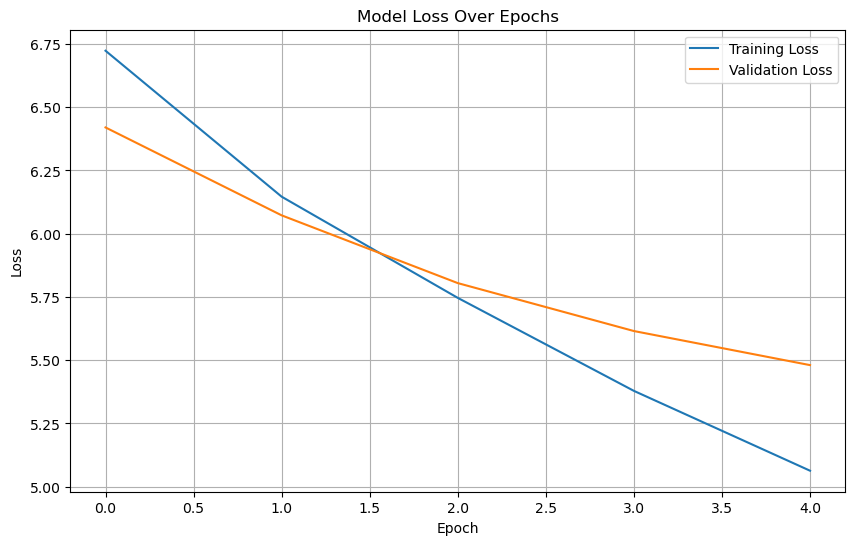

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [30]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """
    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)
    
    # Apply temperature to adjust the probability distribution
    temperature = 1.0  # You can experiment with different values
    yhat = np.asarray(yhat).astype('float64')
    yhat = np.log(yhat + 1e-8) / temperature
    yhat = np.exp(yhat) / np.sum(np.exp(yhat))
    
    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())
    
    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words=50):
    """
    Generate new text using the trained model.
    
    Parameters:
    - model: The trained RNN model.
    - tokenizer: The tokenizer used to pre-process the text data.
    - seed_text: The seed text the model will use to generate new text.
    - max_sequence_len: The maximum length of the sequence used to generate new text.
    - num_words: Number of words to generate.
    
    Returns:
    - The generated text as a single string.
    """
    output_text = seed_text
    
    for _ in range(num_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Pad the sequences to the maximum length
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        
        # Predict the next word
        predicted = get_predicted_word(model, token_list)
        
        # Get the word from the index
        predicted_word = tokenizer.index_word.get(predicted, "<OOV>")
        
        # Append the predicted word to the output text
        output_text += " " + predicted_word
        
        # Update the seed text by removing the first word and adding the predicted word
        seed_text = ' '.join(output_text.split(' ')[-max_sequence_len:])
        
        # (Bonus) Print each word as it's generated
        print(predicted_word, end=' ', flush=True)
    
    print()  # For a new line after generation
    return output_text

In [32]:
# Test the text generation function
generate_text(model, tokenizer, 'tom', SEQ_LENGTH)

retired for both distributing and watching him approaching outward many chapter x and he asked reverence of all colour and meantime sense of day his face or a moment said “heavens hugh  the rightful king that hath a lie across nearer yes  thy tell me thou contrived for all alleys 


'tom retired for both distributing and watching him approaching outward many chapter x and he asked reverence of all colour and meantime sense of day his face or a moment said “heavens hugh \xa0the rightful king that hath a lie across nearer yes \xa0thy tell me thou contrived for all alleys'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [33]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-02 09:44:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 41s  

2024-12-02 09:47:27 (5.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [35]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [36]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define a new Sequential model with the embedding layer
refined_model = Sequential([
    embedding_layer,  # Use the pre-trained embedding layer
    LSTM(128, return_sequences=False),  # LSTM layer with 128 units
    Dense(VOCAB_SIZE, activation='softmax')  # Output layer
])
    
# Compile the refined model
refined_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
# Display the model summary
refined_model.summary()
    
# Train the refined model
history_refined = refined_model.fit(
    X_train, y_train,
    epochs=10,               # Train for more epochs to improve performance
    batch_size=128,
    validation_data=(X_val, y_val)
)
    
print("Refined model training complete.")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 10000)             1290000   
                                                                 
Total params: 2407248 (9.18 MB)
Trainable params: 1407248 (5.37 MB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________
Epoch 1/10
1419/1419 [==============================] - 50s 35ms/step - loss: 6.7018 - accuracy: 0.0762 - val_loss: 6.3616 - val_accuracy: 0.0922
Epoch 2/10
1419/1419 [==============================] - 49s 35ms/step - loss: 6.0349 - accuracy: 0.1049 - val_loss: 5.9466 - val_a

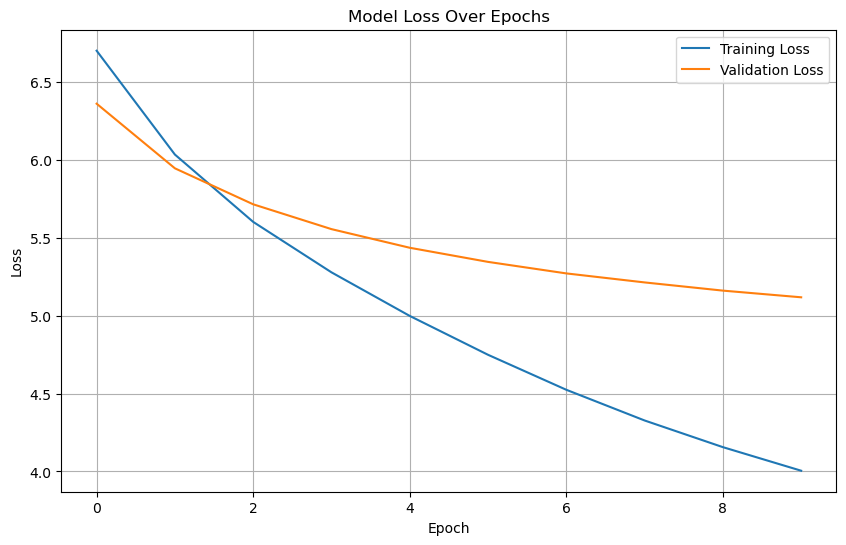

In [38]:
# for refined model

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_refined.history['loss'], label='Training Loss')
plt.plot(history_refined.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [40]:
# Test the text generation function with a seed word for refined_model
generated_text = generate_text(refined_model, tokenizer, 'tom', SEQ_LENGTH, num_words=50)
print("\nGenerated Text:")
print(generated_text)


“the reflected down and this other are 8 pageants about “with “tom it to go ' 'all was on a's hall was the mills been by these harmless in that just a solitary somewhere at i was him shudder thought to him emotions that was obliged away from his kingdom 

Generated Text:
tom “the reflected down and this other are 8 pageants about “with “tom it to go ' 'all was on a's hall was the mills been by these harmless in that just a solitary somewhere at i was him shudder thought to him emotions that was obliged away from his kingdom


## Model Performance Comparison

I've compared the performance of the **base model** and the **refined model** based on their training logs:

### Base Model
- **Training Duration**: 5 epochs
- **Final Training Loss**: 5.0631
- **Final Training Accuracy**: 16.07%
- **Final Validation Loss**: 5.4805
- **Final Validation Accuracy**: 14.72%

### Refined Model
- **Training Duration**: 10 epochs
- **Final Training Loss**: 4.0047
- **Final Training Accuracy**: 23.19%
- **Final Validation Loss**: 5.1183
- **Final Validation Accuracy**: 16.98%

### Observations
- **Improved Performance**: The refined model, which incorporates pre-trained GloVe embeddings and is trained for more epochs, shows a noticeable improvement in both training and validation accuracy compared to the base model.
- **Reduced Loss**: There's a significant reduction in both training and validation loss, indicating better model learning and generalization.
- **Overfitting Check**: While the refined model performs better, the gap between training and validation accuracy suggests that there's still room to mitigate potential overfitting. Further refinements, such as adding dropout layers or increasing the dataset size, might help enhance performance.

---

Overall, integrating pre-trained embeddings and extending the training duration has positively impacted the model's ability to learn and generalize from the data.


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.